In [1]:
import os
import cv2
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable

import torchvision.datasets as datasets
from torchvision.utils import make_grid

import tqdm
import matplotlib.pyplot as plt

In [2]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

In [3]:
# !tar -xzf facades.tar.gz

In [4]:
dir_train = '/content/facades/train'
dir_test = '/content/facades/test'
dir_val = '/content/facades/val'

In [5]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, split='train'):
        self.dir = image_dir
        self.files = os.listdir(self.dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.dir, self.files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        w = image.shape[1]
        w = w // 2
        input_image = image[:, w:, :]
        real_image = image[:, :w, :]
        transformation = transforms.Compose([
        transforms.ToTensor(),
        ])
        return transformation(input_image), transformation(real_image)

In [6]:
train_dataset = ImageDataset(dir_train, split='train')
test_dataset = ImageDataset(dir_test, split='test')
val_dataset = ImageDataset(dir_val, split='val')

In [7]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


## Generator

In [9]:
class ConvBlock(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            torch.nn.Conv2d(in_channels, out_channels, 3, bias=False, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, 3, bias=False, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )
        
class ResConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_path = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, bias=False, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, 3, bias=False, padding=1),
            torch.nn.BatchNorm2d(out_channels),
        )
        self.residual_path = torch.nn.Conv2d(in_channels, out_channels, 1)
        self.last_relu = torch.nn.ReLU(inplace=True)
        
    def forward(self, x):
        result = self.main_path(x)
        residual = self.residual_path(x)
        result = self.last_relu(result + residual)
        return result

In [10]:
class UNetDown(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, block):
        layers = [
            torch.nn.MaxPool2d(2),
            block(in_channels, out_channels)
        ]
        super().__init__(*layers)
     
    
class UNetUp(torch.nn.Module):
    def __init__(self, in_channels, out_channels, block):
        super().__init__()
        self._transposed_convolution = torch.nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self._convolutions = block(out_channels * 2, out_channels)
    
    def forward(self, x_down, x_up):
        x_up = self._transposed_convolution(x_up)
        
        b_down, c_down, h_down, w_down = x_down.shape
        b_up, c_up, h_up, w_up = x_up.shape
        if (h_up > h_down) or (w_up > w_down):
            raise ValueError("Up tensor must be smaller than down tensor")
        offset = ((h_down - h_up) // 2, (w_down - w_up) // 2)
        x_down_cropped = x_down[:, :, offset[0]:offset[0] + h_up, offset[1]:offset[1] + w_up]
        
        x = torch.cat((x_down_cropped, x_up), axis=1)
        result = self._convolutions(x)
        return result


class Generator(torch.nn.Module):
    def __init__(self, num_classes, num_scales=4, base_filters=64, block=ConvBlock):
        super().__init__()
        self._input_convolutions = block(3, base_filters)
        
        layers = []
        filters = base_filters
        for i in range(num_scales):
            layers.append(UNetDown(filters, filters * 2, block))
            filters *= 2
        self._down_layers = torch.nn.Sequential(*layers)
        
        layers = []
        for i in range(num_scales):
            layers.append(UNetUp(filters, filters // 2, block))
            filters //= 2
        self._up_layers = torch.nn.Sequential(*layers)
        
        self._output_convolution = torch.nn.Conv2d(filters, num_classes, 1)
        self.initialize_weights()
        
    def forward(self, x):
        down_results = [self._input_convolutions(x)]
        for layer in self._down_layers:
            down_results.append(layer(down_results[-1]))
        x = down_results[-1]
        for i, layer in enumerate(self._up_layers):
            x = layer(down_results[-2 - i], x)
        x = self._output_convolution(x)
        return x
     
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

In [11]:
USE_RESIDUALS = True
generator = Generator(num_classes=3,
            num_scales=4,
            base_filters=64,
            block=ResConvBlock if USE_RESIDUALS else ConvBlock)
generator.to(device)

Generator(
  (_input_convolutions): ResConvBlock(
    (main_path): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (residual_path): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (last_relu): ReLU(inplace=True)
  )
  (_down_layers): Sequential(
    (0): UNetDown(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResConvBlock(
        (main_path): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)

In [12]:
example_input, example_target = next(iter(test_dataset))

In [13]:
def generate_images(model, test_input, target):
    test_input = test_input[np.newaxis,:,:,:].to(device)
    target = target.to(device)
    prediction = model(test_input)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], target, prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].to('cpu').detach().permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.show()

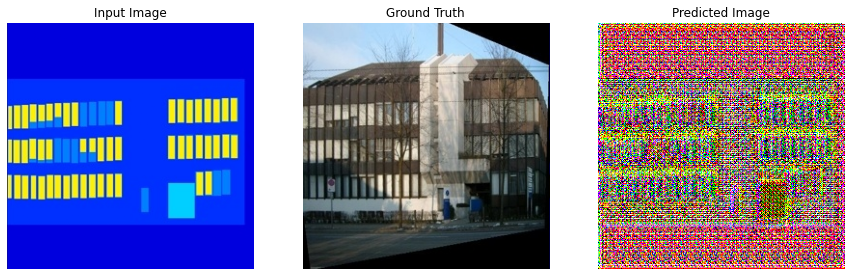

In [14]:
generate_images(generator, example_input, example_target)

## Discriminator

In [15]:
class Discriminator(torch.nn.Module):
    def __init__(self, num_scales=4, base_filters=64, block=ConvBlock):
        super().__init__()
        self._input_convolutions = block(6, base_filters)
        
        layers = []
        filters = base_filters
        for i in range(num_scales):
            layers.append(UNetDown(filters, filters * 2, block))
            filters *= 2
        self._down_layers = torch.nn.Sequential(*layers)
        self._last_layers = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters * 2, 3, padding=1),
            torch.nn.BatchNorm2d(filters * 2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(filters * 2, 1, 3, padding=1)
        )
        
    def forward(self, inp, tar):
        x = torch.cat([inp, tar], dim=1)
        down_results = [self._input_convolutions(x)]
        for layer in self._down_layers:
            down_results.append(layer(down_results[-1]))
        x = down_results[-1]
        x = self._last_layers(x)
        return x
     
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

In [16]:
discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (_input_convolutions): ConvBlock(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (_down_layers): Sequential(
    (0): UNetDown(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

## Losses

In [17]:
basic_loss = torch.nn.BCEWithLogitsLoss()

In [18]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = basic_loss(torch.ones_like(disc_generated_output), disc_generated_output)
    l1 = nn.L1Loss()
    l1_loss = l1(gen_output, target)
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = basic_loss(torch.ones_like(disc_real_output), disc_real_output)
    generated_loss = basic_loss(torch.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def discriminator_loss_real(disc_real_output):
    real_loss = basic_loss(torch.ones_like(disc_real_output), disc_real_output)
    return real_loss

def discriminator_loss_fake(disc_generated_output):
    generated_loss = basic_loss(torch.zeros_like(disc_generated_output), disc_generated_output)
    return generated_loss

## Optimizers

In [20]:
lr, beta1, beta2 = 0.0002, 0.5, 0.999
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

## Training

In [21]:
def train_step(input_image, target):
    gen_output = generator(input_image)
    disc_real_output = discriminator(input_image, target)
    disc_generated_output = discriminator(input_image, gen_output)

    disc_loss = discriminator_loss(disc_real_output, disc_generated_output.detach())
    disc_optimizer.zero_grad()
    disc_loss.backward()
    
    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    gen_optimizer.zero_grad()
    gen_loss.backward()

    disc_optimizer.step()
    gen_optimizer.step()   
    return disc_loss, gen_loss

In [22]:
def fit(train_loader, test_dataset, num_epochs):
    generator.train()
    discriminator.train()
    gen_losses = []
    disc_losses = []
    example_input, example_target = next(iter(test_dataset))
    for epoch in range(num_epochs):
        for input_image, target in tqdm.tqdm(train_loader):
            input_image = input_image.to(device)
            target = target.to(device)
            disc_loss, gen_loss = train_step(input_image, target)
            gen_losses.append(gen_loss.to('cpu').detach().numpy())
            disc_losses.append(disc_loss.to('cpu').detach().numpy())
        if epoch % 3 == 0:
          generate_images(generator, example_input, example_target)
    return gen_losses, disc_losses

100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


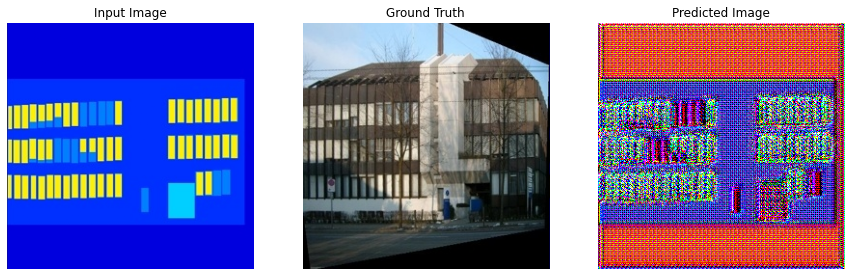

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


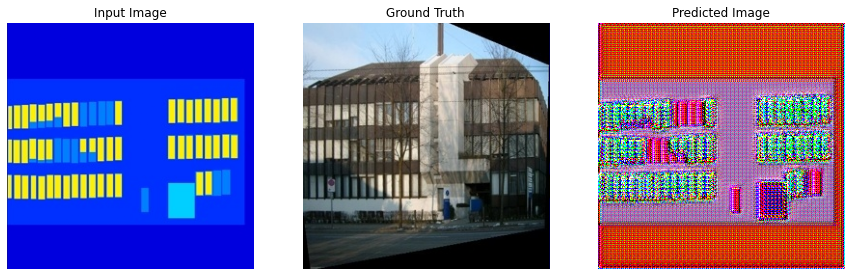

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


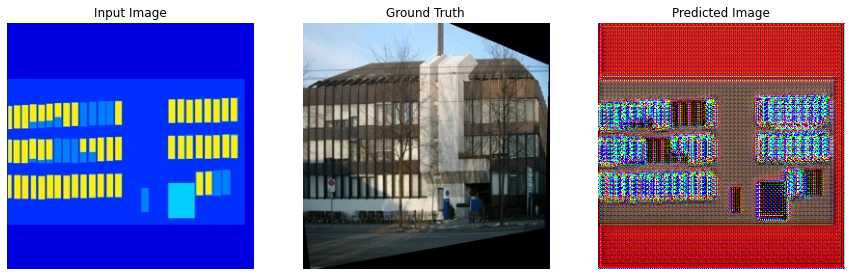

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


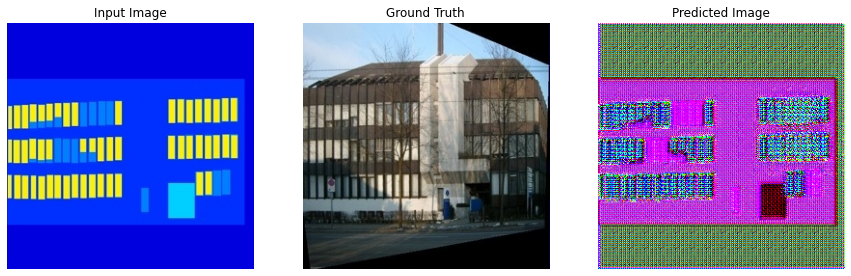

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


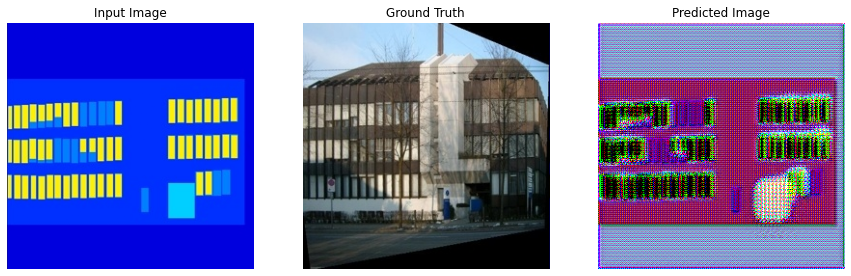

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


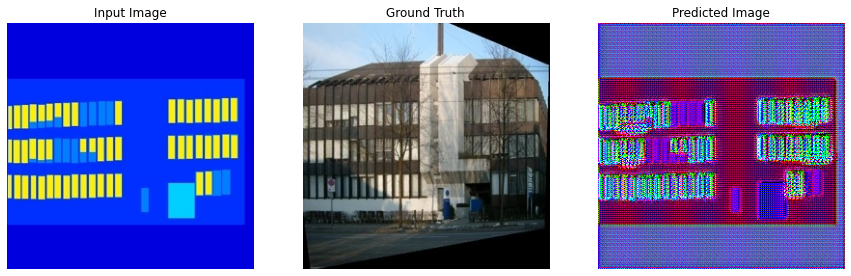

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


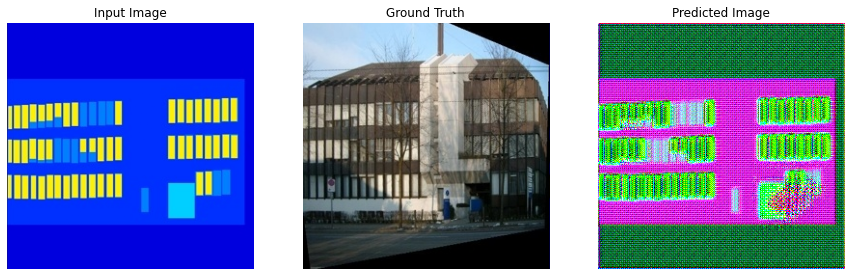

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


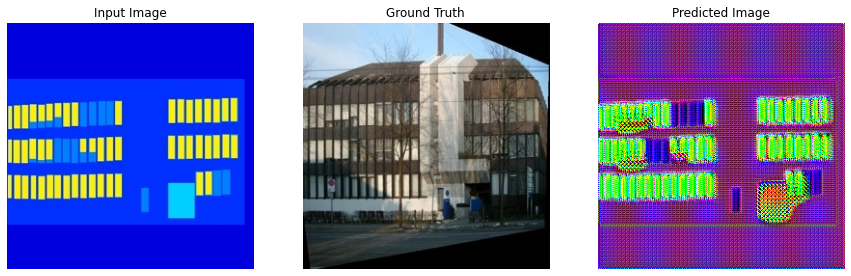

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


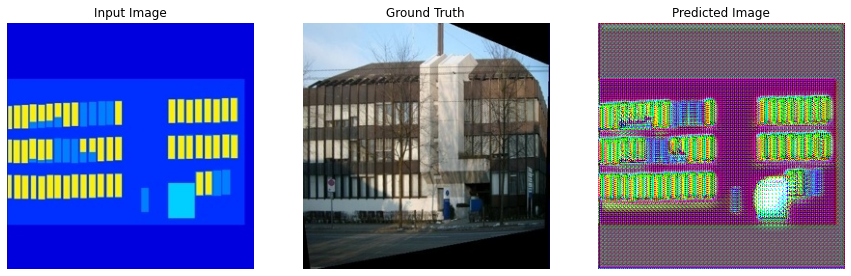

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


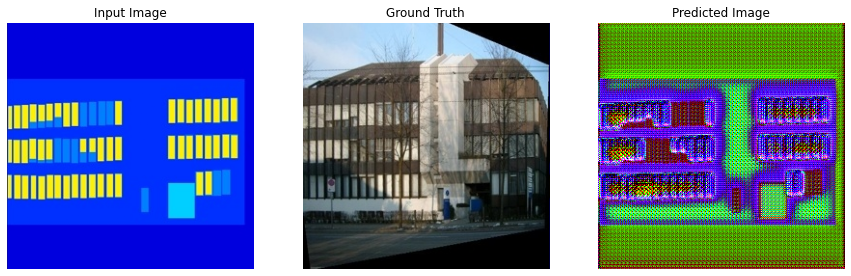

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


In [23]:
gen_losses, disc_losses = fit(train_loader, test_dataset, num_epochs=30)

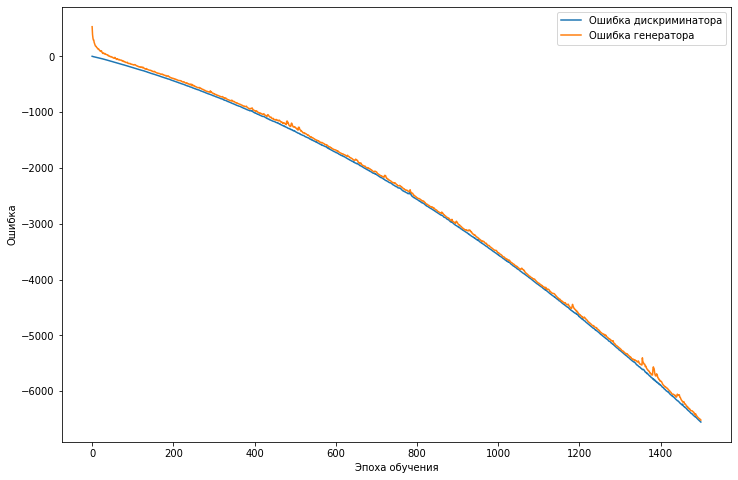

In [25]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Ошибка дискриминатора')
    ax.plot(x_test, g_losses, label='Ошибка генератора')
    ax.legend()
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')

plot_losses(disc_losses, gen_losses)

Для более успешного обучения нужно добавить аугментации данных.